In [1]:
import torch
import torch_pruning as tp
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from train import original_train
from test import test
from pruning import pruning
from experi_pruning_finetuning import experi_pruning_finetuning
from quantization import quantize_qint8

import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from torchsummary import summary
import pandas as pd

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)



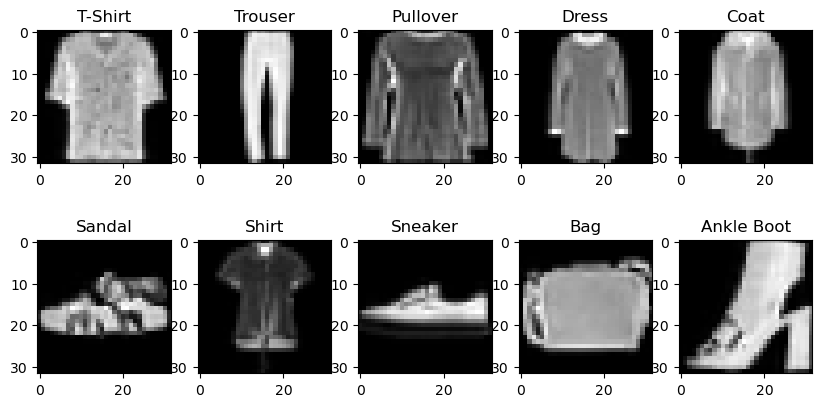

In [2]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root = "data", train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = "data", train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = trainset, shuffle = True, batch_size = 32)
test_loader = torch.utils.data.DataLoader(dataset = testset, shuffle = False, batch_size = 32)


label_tags = {
    0:'T-Shirt',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot'
}

iter_trainloader = iter(train_loader)
imgs, labels = next(iter_trainloader)
imgs_2, labels_2 = next(iter_trainloader)

figure = plt.figure(figsize = (10,5))
rows, cols = (2,5)
for i in range(0, 10):
    img_idxs = np.argwhere(labels == i)[0]
    if img_idxs.shape[0] == 0:
        print('두번째 loader')
        img_idx = np.argwhere(labels_2 == i)[0][0]
    else: 
        img_idx = img_idxs[0]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label_tags[i])
    plt.imshow(imgs[img_idx].squeeze(), cmap = 'grey')
plt.show()



In [3]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **\* Base model train & test**

In [5]:
"""
origin_model = LeNet_5().to(device)
origin_model = original_train(origin_model, device, train_loader)

acc, inference_time = test(origin_model, device, test_loader)
print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
macs, nparams = tp.utils.count_ops_and_params(origin_model, torch.randn(1, 1, 32, 32).to(device))
print('n_params:', nparams)
print('macs:', macs)

torch.save(origin_model.state_dict(), 'origin_model.pth')
"""

accuracy: 89.390
inference time: 7.398μs
n_params: 61706
macs: 429342.0


**Base model cannot be Fully Optimized** due to resource limitations of Jetson Nano (Accuracy 89%)<br>
-> It is necessary to proceed model compression, keeping this in mind 

In [5]:
import warnings
warnings.filterwarnings('ignore')
                        
origin_model = LeNet_5().to(device)
origin_model.load_state_dict(torch.load('origin_model.pth'))

<All keys matched successfully>

## ------ **Model Compression Experimentation (Pruning & Quantization)** ------

# **[ Pruning ]**


`Importance Score` : Mean of Absolute weights Per Channel


`List of Hyper-Parameters` to be determined through Experimentation

**[Pruning]**

- **Global VS Local** Pruning
- **(Conv + Linear) VS Only Linear** Pruning
- **\# of Iterative step**
- **Pruning ratio**

**[Finetuning]**
- **w/ or w/o Finetuning**
- **Finetuning epoch**
- **Finetuning learning rate**
- **w/ or w/o re-initializing** for finetuning

======================================================================

### **\* Global Pruning VS Local Pruning**
-> Check Base model's Importance Score per channels

In [15]:
def get_conv_linear_layers(model) -> list:
    layers = []
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear) and layer.out_features != 10:
            layers.append(layer)
        if isinstance(layer, torch.nn.Conv2d):
            layers.append(layer)
    return layers

In [16]:
def get_channel_importance(model) -> list:
    layers = get_conv_linear_layers(model)
    channel_importance = []
    
    for layer in layers:
        score = layer.weight.abs().flatten(1).mean(1)
        channel_importance.append(score)
    return channel_importance

In [17]:
channel_importance = get_channel_importance(origin_model)

index = [layer_name for l, layer_name in zip(channel_importance, ['conv1', 'conv2', 'linear1', 'linear2']) for j in range(len(l))]
score = torch.concat(channel_importance)

importance_df = pd.DataFrame(score.cpu().detach().numpy(), index = index, columns = ['score'])
importance_df.sort_values('score').head(10)

,score
linear1,0.025061
linear1,0.025188
linear1,0.025299
linear1,0.025407
linear1,0.026118
linear1,0.026239
linear1,0.026466
linear1,0.026470
linear1,0.026872
linear1,0.026944


In [18]:
def plot_scatter_channel_importance(model, model_name, ax):
    channel_importance = get_channel_importance(model) # list
    layer_names = ['conv1', 'conv2', 'linear1', 'linear2']
    
    for idx, (layer, layer_name) in enumerate(zip(channel_importance, layer_names)):
        score = layer.cpu().detach().numpy()
        ax.scatter([idx]*len(score), score, label = layer_name)
        
    ax.legend()
    ax.set_xticks(ticks = range(len(layer_names)), labels = layer_names)
    ax.set_xlabel(model_name)
    ax.set_ylabel('Importance Score')
    ax.set_title('Importance Score of Channels by Layers')


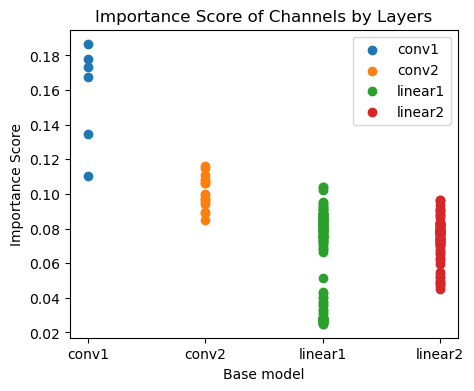

In [23]:
fig, ax = plt.subplots(1, figsize=(5,4))
plot_scatter_channel_importance(origin_model, 'Base model', ax)

- *Considering that Base model is not fully optimized(accuracy 89%)* -> need to avoid further performance degradation


- conv layers have fewer channels than linear layers, but conv layers play more important role than linear layer based on mean importance score
    -> conv layers contribute significantly to feature extraction
- Applying **Global pruning** could prune many conv channels -> could result in performance degradation
- **Local pruning** prunes the channels of layers according to the pruning ratio setting

**\* To preserve few channels of conv layers**, apply `Local pruning`

### **\* w/ or w/o Finetuning after pruning**



#### w/o finetuning

In [25]:
# Just Pruning, Before finetuning
model = copy.deepcopy(origin_model)
_model_50, _acc_50, _params_50, _mmac_50, _inference_time_50, _df_50 = pruning(model, 0.5, device, test_loader, 5)
_df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,11.180019
step 1,81.09,48737,330483,6.939554
step 2,72.39,37391,243147,6.219935
step 3,71.26,29919,225576,6.215596
step 4,55.339996,21194,153236,6.250548
step 5,44.62,15738,140156,6.058407


#### w/ finetuning

In [26]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_50, acc_50, params_50, mmac_50, inference_time_50, df_50 = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)
df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.196093
step 1,90.909996,48737,330483,6.326246
step 2,91.11,37391,243147,6.395602
step 3,91.64,29919,225576,7.290125
step 4,89.19,21194,153236,6.280446
step 5,88.96,15738,140156,7.738471


In [28]:
def make_list(m):
    return [i.item() if isinstance(m, np.ndarray) else i for i in m ]

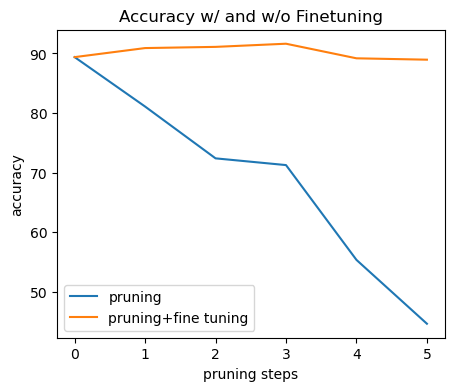

In [32]:
a = list(range(6))
b = make_list(_acc_50)

x = list(range(6))
y = make_list(acc_50)

fig, ax = plt.subplots(1, figsize=(5,4))
ax.set_title('Accuracy w/ and w/o Finetuning')
ax.set_xlabel('pruning steps')
ax.set_ylabel('accuracy')
ax.plot(a,b, label = 'pruning')
ax.plot(x,y, label = 'pruning+fine tuning')
ax.legend()

plt.show()

Finetuning after pruning plays a crucial role in recovering performance loss due to pruned parameters

### **\* Finetuning epoch**

In [6]:
model = copy.deepcopy(origin_model)
model_epoch1, acc_epoch1, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, finetuning_epoch=1)

model = copy.deepcopy(origin_model)
model_epoch2, acc_epoch2, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, finetuning_epoch=2)

model = copy.deepcopy(origin_model)
model_epoch3, acc_epoch3, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, finetuning_epoch=3)

model = copy.deepcopy(origin_model)
model_epoch4, acc_epoch4, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, finetuning_epoch=4)

model = copy.deepcopy(origin_model)
model_epoch5, acc_epoch5, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, finetuning_epoch=5)

In [9]:
pd.DataFrame({'Acc(%)':[acc_epoch1[0], acc_epoch1[-1], acc_epoch2[-1], acc_epoch3[-1], acc_epoch4[-1], acc_epoch5[-1]]},
             index = ['Base'] + [f'finetuning epoch {i}' for i in list(range(1, 6))])

,Acc(%)
Base,89.39
finetuning epoch 1,85.81999
finetuning epoch 2,86.439995
finetuning epoch 3,87.88
finetuning epoch 4,88.33
finetuning epoch 5,88.96


Since training epoch (5) is too small, it's difficult to expect performance improvement w/ a small # of finetuning epochs

-> based on accuracy results, set `finetuning epoch 5`

### **\* re-initializing VS retaining remaining weights during finetuning**

In [6]:
model = copy.deepcopy(origin_model)
model_no_init, acc_no_init, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, re_initialize = False)

model = copy.deepcopy(origin_model)
model_random_init, acc_random_init, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, re_initialize = 'random')

model = copy.deepcopy(origin_model)
model_he_init, acc_he_init, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, re_initialize = 'he')

In [14]:
pd.DataFrame({'Acc(%)':[acc_no_init[0], acc_no_init[-1], acc_random_init[-1], acc_he_init[-1]]},
             index = ['Base', 'retain remaining weights', 'random re-init', 'He re-init'])

,Acc(%)
Base,89.39
retain remaining weights,88.96
random re-init,70.49
He re-init,74.67


It is more effective to retain the remaining weights for fine-tuning

### **\* # of Iterative Pruning step**

In [9]:
model = copy.deepcopy(origin_model)
model_4, acc_4, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 4, 1e-4)

model = copy.deepcopy(origin_model)
model_3, acc_3, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 3, 1e-4)

model = copy.deepcopy(origin_model)
model_2, acc_2, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 2, 1e-4)

model = copy.deepcopy(origin_model)
model_1, acc_1, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 1, 1e-4)

In [11]:
pd.DataFrame({'Acc(%)':[acc_1[0], acc_1[-1], acc_2[-1], acc_3[-1], acc_4[-1], acc_5[-1]]},
             index = ['Base'] + list(range(1, 6)))

,Acc(%)
Base,89.229996
1,86.57
2,85.659996
3,87.93
4,87.67
5,88.259995


Set the `Iterative step to 5` based on the Accuracy results

### **\* Finetuning learning rate**

In [12]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_4, acc_4, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)

model = copy.deepcopy(origin_model)
model_5, acc_5, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-5)

model = copy.deepcopy(origin_model)
model_6, acc_6, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-6)

In [14]:
import pandas as pd
pd.DataFrame({"Accuracy(%)" : [acc_4[0].round(), acc_4[-1], acc_5[-1], acc_6[-1]]},
             index = ['Base', 'lr * 1/10', 'lr * 1/100', 'lr * 1/1000'])

,Accuracy(%)
Base,89.0
lr * 1/10,88.259995
lr * 1/100,81.75
lr * 1/1000,57.82


Select `Finetuning learning rate 1e-4` (1/10 * training lr)

### **\* (Conv + Linear) Pruning VS Only Linear Pruning**
compare under the same # of parameters

1) Pruning applied to both (Conv + Linear) -> pruning ratio 0.5 (75% parameter reduction)
2) Pruning applied to Linear layers only -> pruning ratio 0.75 (75% parameter reduction)

In [12]:
model = copy.deepcopy(origin_model)
model_mix_pruning, acc_mix_pruning, param_mix_pruning, mac_mix_pruning, inference_time_mix_pruning, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, "prune_conv_and_linear")

model = copy.deepcopy(origin_model)
model_only_prune_linear_layer, acc_only_prune_linear_layer, param_only_prune_linear_layer, mac_only_prune_linear_layer, inference_time_only_prune_linear_layer, _ = experi_pruning_finetuning(model, 0.75, device, test_loader, 5, 1e-4, "only_prune_linear_layer")

In [13]:
import pandas as pd
pd.DataFrame({'# of parameters': [param_mix_pruning[0], param_mix_pruning[-1], param_only_prune_linear_layer[-1]], 
              'Acc(%)':[acc_mix_pruning[0], acc_mix_pruning[-1], acc_only_prune_linear_layer[-1]],
              'MACs':[mac_mix_pruning[0], mac_mix_pruning[-1], mac_only_prune_linear_layer[-1]],
              'Inference time': [inference_time_mix_pruning[0], inference_time_mix_pruning[-1], inference_time_only_prune_linear_layer[-1]]},
             index = ['Base', 'conv+linear pruning', 'only linear pruning'])

,# of parameters,Acc(%),MACs,Inference time
Base,61706,89.229996,429342,9.623528
conv+linear pruning,15738,88.259995,140156,6.801128
only linear pruning,15473,90.01,383109,7.143116


reduce # of parameters to 1/4 * base_model
-> (Conv + Linear pruning) : pruning ratio 0.5     //   Only Linear pruning : pruning ratio 0.75

- **(Conv + Linear)** pruning : 0.97% accuracy dropped, but significant reduction on MACs due to conv layer pruning (conv: computationally expensive)
- **Only Linear** pruning : 0.78% accuracy improved, but no significant reduction on MACs due to no conv layer pruning
- (Conv + Linear) pruning's inference time is faster than only linear pruning due to fewer operations

-> SELECT `(Conv + Linear) Pruning` for significant reduction on MACs w/ only 1% accuracy drop

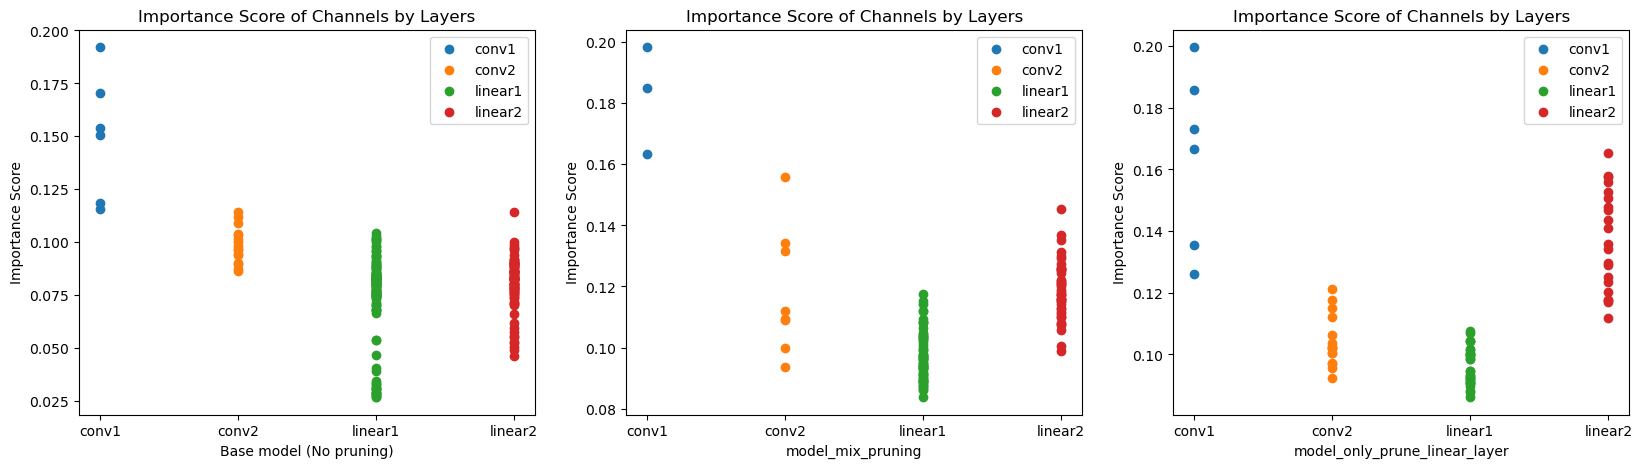

In [239]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
plot_scatter_channel_importance(origin_model, 'Base model (No pruning)', ax[0], )
plot_scatter_channel_importance(model_mix_pruning, 'model_mix_pruning', ax[1])
plot_scatter_channel_importance(model_only_prune_linear_layer, 'model_only_prune_linear_layer', ax[2])

### **\* Pruning Ratio**

#### pruning ratio : 50%

In [33]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_50, acc_50, params_50, mmac_50, inference_time_50, df_50 = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)
df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,10.347939
step 1,90.909996,48737,330483,6.304526
step 2,91.11,37391,243147,6.303883
step 3,91.64,29919,225576,6.071687
step 4,89.19,21194,153236,6.225443
step 5,88.96,15738,140156,8.978605


#### pruning ratio : 60%

In [34]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_60, acc_60, params_60, mmac_60, inference_time_60, df_60 = experi_pruning_finetuning(model, 0.6, device, test_loader, 5, 1e-4)
df_60

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,8.499241
step 1,90.88,47227,328973,6.832504
step 2,91.08,35143,240899,6.352162
step 3,89.21,24535,164201,6.408811
step 4,88.21,16297,140715,6.334496
step 5,85.60999,9563,82741,6.281424


#### Pruning ratio: 70%

In [35]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_70, acc_70, params_70, mmac_70, inference_time_70, df_70 = experi_pruning_finetuning(model, 0.7, device, test_loader, 5, 1e-4)
df_70

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,9.372425
step 1,90.85,43564,312736,6.476974
step 2,90.88,30781,226438,6.433797
step 3,88.4,20206,152248,6.171870
step 4,85.42,11839,90166,6.136489
step 5,77.86,4951,36789,6.595349


#### pruning ratio : 80%

In [36]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_80, acc_80, params_80, mmac_80, inference_time_80, df_80 = experi_pruning_finetuning(model, 0.8, device, test_loader, 5, 1e-4)
df_80

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,8.581424
step 1,90.79,42148,311320,6.410360
step 2,90.4,26699,212257,6.114101
step 3,87.5,16297,140715,6.310463
step 4,84.25,7355,75384,6.234336
step 5,72.75,2406,31570,5.922651


#### pruning ratio : 90%

In [37]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_90, acc_90, params_90, mmac_90, inference_time_90, df_90 = experi_pruning_finetuning(model, 0.9, device, test_loader, 5, 1e-4)
df_90

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.073259
step 1,89.99,40787,256642,6.283426
step 2,88.96,24535,164201,6.284118
step 3,85.549995,12607,90934,6.577945
step 4,77.72,4485,36323,6.319380
step 5,53.289997,524,24340,5.850053


## **\* FINAL RESULTS**

(comparison of the four metrics based on the pruning ratios)

In [38]:
import pandas as pd
pd.DataFrame({'acc(%)':[acc_50[0], acc_50[-1], acc_60[-1], acc_70[-1], acc_80[-1], acc_90[-1]],
              'n_params' : [params_50[0], params_50[-1], params_60[-1], params_70[-1], params_80[-1], params_90[-1]],
              'MACs': [mmac_50[0], mmac_50[-1], mmac_60[-1], mmac_70[-1], mmac_80[-1], mmac_90[-1]],
              'inference time(μs)': [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]],},
             index = ['Base'] + [f'{i}%' for i in range(50, 100, 10)])


,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,10.347939
50%,88.96,15738,140156,8.978605
60%,85.60999,9563,82741,6.281424
70%,77.86,4951,36789,6.595349
80%,72.75,2406,31570,5.922651
90%,53.289997,524,24340,5.850053


#### * Visualization across Pruning Ratios

In [42]:
def plot_metric(metric_list: list, metric_name: str, ax):
    x = list(range(6))
    ax.set_title(metric_name)
    for (metric_ratio, ratio_name) in zip(metric_list, ['50%', '60%', '70%', '80%', '90%']):
        ax.plot(x, make_list(metric_ratio), label = ratio_name)
    ax.legend()

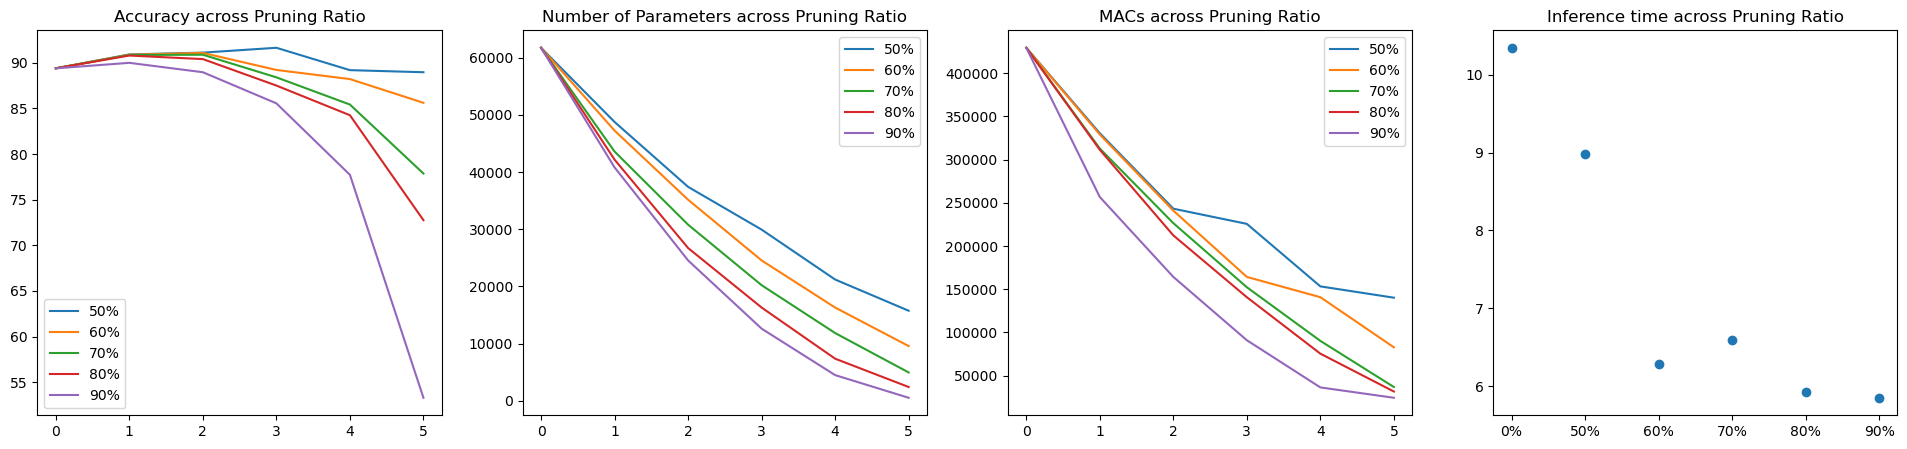

In [43]:
fig, ax = plt.subplots(1,4, figsize=(24,5))

plot_metric([acc_50, acc_60, acc_70, acc_80, acc_90], 'Accuracy across Pruning Ratio', ax[0])
plot_metric([params_50, params_60, params_70, params_80, params_90], 'Number of Parameters across Pruning Ratio', ax[1])
plot_metric([mmac_50, mmac_60, mmac_70, mmac_80, mmac_90], 'MACs across Pruning Ratio', ax[2])

x = ['0%'] + [str(i) + '%' for i in range(50, 100, 10)]
y = [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]]
ax[3].set_title('Inference time across Pruning Ratio')
ax[3].scatter(x, y)
plt.show()

### * Check number of channels across pruning ratio
(Only check the weight, except bias)

In [39]:
def get_num_channels(model):
    return [layer.weight.shape[0] for layer in get_conv_linear_layers(model)]

In [44]:
channels_base = get_num_channels(origin_model)
channels_50 = get_num_channels(model_50)
channels_60 = get_num_channels(model_60)
channels_70 = get_num_channels(model_70)
channels_80 = get_num_channels(model_80)
channels_90 = get_num_channels(model_90)

layer_name = ['Base'] + [f'{i}%' for i in range(50, 100, 10)]
channels_list = [channels_base, channels_50, channels_60, channels_70, channels_80, channels_90]
index = ['conv1', 'conv2', 'linear1', 'linear2']

channels_df = pd.DataFrame({n: channel for (n, channel) in zip(layer_name, channels_list)},
                           index = index)

channels_df.loc['-'] = ['-']*6
channels_df.loc['Accuracy(%)'] = [acc_50[0], acc_50[-1], acc_60[-1], acc_70[-1], acc_80[-1], acc_90[-1]]
channels_df.loc['n_params'] = [params_50[0], params_50[-1], params_60[-1], params_70[-1], params_80[-1], params_90[-1]]
channels_df.loc['MACs'] = [mmac_50[0], mmac_50[-1], mmac_60[-1], mmac_70[-1], mmac_80[-1], mmac_90[-1]]
channels_df.loc['Inference time(μs)'] = [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]]
channels_df

,Base,50%,60%,70%,80%,90%
conv1,6,3,2,1,1,1
conv2,16,8,6,4,3,1
linear1,120,60,48,36,23,11
linear2,84,42,33,25,16,8
-,-,-,-,-,-,-
Accuracy(%),89.39,88.96,85.60999,77.86,72.75,53.289997
n_params,61706,15738,9563,4951,2406,524
MACs,429342,140156,82741,36789,31570,24340
Inference time(μs),10.347939,8.978605,6.281424,6.595349,5.922651,5.850053


* Select a `pruning ratio 0.5` pruned model for quantization

- **Accuracy** : only 0.43% accuracy degradation
- **\# of params** : 1/4 of base model
- **MACs** : 1/3 of base model



======================================================================


`Summary of all Hyper-parameters` determined through Experimentation

**[Pruning]**
- **Local Pruning**
- **Conv + Linear** Pruning
- **Iterative step** : 5
- **Pruning ratio** : 0.5

**[Finetuning]**
- **w/ Finetuning**
- **Finetuning epoch** : 5
- **Finetuning learning rate** : 1e-4 (1/10 * training lr)
- **w/o re-initializing** for finetuning (retain remaining weights after pruning)


In [72]:
#torch.save(model_50.state_dict(), 'model_50.pth')

# **[ Quantization ]**

In [34]:
quantize_qint8_model50 = quantize_qint8(model_50.to('cpu'))
quantize_qint8_model50

# Linear -> DynamicQuantizedLinear 

LeNet_5(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=200, out_features=60, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=60, out_features=42, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=42, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [63]:
print('#########################################')
print('########### Before Quantization #########')
print('#########################################')

acc, inference_time = test(model_50.to('cpu'), 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(model_50.to('cpu'), torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

print()
print('#########################################')
print('############ After Quantization #########')
print('#########################################')

acc, inference_time = test(quantize_qint8_model50, 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(quantize_qint8_model50, torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

#########################################
########### Before Quantization #########
#########################################
accuracy: 88.260
inference time: 14.269μs
n_params: 15738
macs: 140156.0

#########################################
############ After Quantization #########
#########################################
accuracy: 88.210
inference time: 16.366μs
n_params: 686
macs: 125104.0


### Summary of pruned 50%

In [36]:
summary(model_50, (1,32,32), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 3, 28, 28]              78
         MaxPool2d-2            [32, 3, 14, 14]               0
            Conv2d-3            [32, 8, 10, 10]             608
         MaxPool2d-4              [32, 8, 5, 5]               0
            Linear-5                   [32, 60]          12,060
            Linear-6                   [32, 42]           2,562
            Linear-7                   [32, 10]             430
Total params: 15,738
Trainable params: 15,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.99
Params size (MB): 0.06
Estimated Total Size (MB): 1.17
----------------------------------------------------------------


### Summary of pruned + quantized model

In [37]:
summary(quantize_qint8_model50, (1,32,32), batch_size=32, device='cpu')


# using torchsummary, parameters for FCL are all recorded as 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 3, 28, 28]              78
         MaxPool2d-2            [32, 3, 14, 14]               0
            Conv2d-3            [32, 8, 10, 10]             608
         MaxPool2d-4              [32, 8, 5, 5]               0
            Linear-5                   [32, 60]               0
            Linear-6                   [32, 42]               0
            Linear-7                   [32, 10]               0
Total params: 686
Trainable params: 686
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.99
Params size (MB): 0.00
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


In [38]:
quantize_qint8_model50.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.scale', 'fc1.zero_point', 'fc1._packed_params.dtype', 'fc1._packed_params._packed_params', 'fc2.scale', 'fc2.zero_point', 'fc2._packed_params.dtype', 'fc2._packed_params._packed_params', 'fc3.scale', 'fc3.zero_point', 'fc3._packed_params.dtype', 'fc3._packed_params._packed_params'])

In [41]:
fc_list = ['fc1', 'fc2', 'fc3']
fc_nparams = []

for i in fc_list:
    n = i + '._packed_params._packed_params'
    weight = quantize_qint8_model50.state_dict()[n][0].numel()
    bias = quantize_qint8_model50.state_dict()[n][1].numel()

    fc_nparams.append(weight+bias)

# After Quantization 
print('################# check number of Parameters after quantization ##################')
for idx, i in enumerate(fc_nparams):
    print(f'fc{idx+1}:', i)
    
# same !!
# It is correct that the number of parameters has not changed

################# check number of Parameters after quantization ##################
fc1: 12060
fc2: 2562
fc3: 430


After quantization, the model's parameter storage format changes

-> It is suspected that torchsummary could not compute paramters due to changes in the storage format

-> The total number of parameters remains the same with 50% pruned model after quantization

### **\* Final Pruned (Ratio 0.5) and Quantized Model** 

In [73]:
import os

def params_size(model, model_name):
    torch.save(model.state_dict(), model_name + '.p')
    size = os.path.getsize(model_name + '.p')
    return round(size / 1024)  # to KB

base = params_size(origin_model, "origin_model")
pruned_50 = params_size(model_50, "model_50")
quantized_50 = params_size(quantize_qint8_model50, "quantized_model50")

print('################# Parameter Size Comparison ##################')
print(f"Base Model Size: {base} KB")
print(f"50% Pruned Model Size: {pruned_50} KB  -> Reduction: {round((1 - pruned_50 / base) * 100, 2)}%")
print(f"50% Pruned + Quantized Model Size: {quantized_50} KB  -> Reduction: {round((1 - quantized_50 / base) * 100, 2)}%")

pd.DataFrame({'Acc(%)': [acc_50[0], acc_50[-1], acc.numpy()],
              '# of params':[61706, 15738, 15738],
             'param size(KB)': [base, pruned_50, quantized_50],
              },
             index = ['Base', '50% pruned', '50% pruned+quantization'])


################# Parameter Size Comparison ##################
Base Model Size: 245 KB
50% Pruned Model Size: 65 KB  -> Reduction: 73.47%
50% Pruned + Quantized Model Size: 23 KB  -> Reduction: 90.61%


,Acc(%),# of params,param size(KB)
Base,89.229996,61706,245
50% pruned,88.259995,15738,65
50% pruned+quantization,88.21,15738,23
